In [1]:
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset, DataLoader

In [2]:
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        tokens = tokenizer.encode(txt)

        for i in range(0, len(tokens)-max_length, stride):
            input_chunk = tokens[i:i+max_length]
            target_chunk = tokens[i+1:i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [3]:
def create_dataloader(txt, max_length=256, stride=128, batch_size=4, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = GPTDataset(txt, tokenizer=tokenizer, max_length=max_length, stride=stride)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, 'd_out should be divisable by num_heads'

        self.num_heads = num_heads
        self.d_out = d_out
        self.head_dim = d_out // num_heads

        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.w_key(x)
        queries = self.w_query(x)
        values = self.w_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_score = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_score.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.proj(context_vec)

        return context_vec
        

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.emb_dim = emb_dim
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale * x + self.shift
        

In [6]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [7]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            GELU(),
            nn.Linear(4*cfg['emb_dim'], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'],
            num_heads=cfg['n_heads']
        )
        self.ffn = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_resd = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_resd(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.drop_resd(x)
        x = x + shortcut

        return x

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch, seq_len = in_idx.shape
        tok_embeddings = self.tok_emb(in_idx)
        pos_embeddings = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeddings + pos_embeddings
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [10]:
def generate_text_simple(model, idx, max_new_tokens, context_length):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_length:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [11]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [12]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [13]:
start_context = "Hello, I'am"
tokenizer = tiktoken.get_encoding('gpt2')
encoded = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor.shape)

torch.Size([1, 5])


In [14]:
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=10,
    context_length=GPT_CONFIG_124M['context_length']
)
print(out)
print(out.shape)

tensor([[15496,    11,   314,     6,   321, 25646, 21652,  4803,  8058,    39,
          6842, 37891, 23487,  7434, 42266]])
torch.Size([1, 15])


In [15]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I'am restoring185house retireH bear confidently 480osit Cot


In [16]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(idx, tokenizer):
    flat = idx.squeeze(0).tolist()
    return tokenizer.decode(flat)

In [17]:
model = GPTModel(GPT_CONFIG_124M)
model.eval()

start_context = "Every efforts moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    context_length=GPT_CONFIG_124M['context_length'],
    max_new_tokens=10
)
print('output:\n', token_ids_to_text(token_ids, tokenizer))

output:
 Every efforts moves you sleevesork FIGHT"))iscKEN Instruct calling attendcipled


In [18]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [588,  428,  11311]]) #  " really like chocolate"]

In [19]:
with torch.no_grad():
    logits = model(inputs)
probs = torch.softmax(logits, dim=-1)
print(probs.shape)

torch.Size([2, 3, 50257])


In [20]:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
for i, o_b in enumerate(token_ids):
    print('context:', token_ids_to_text(inputs[i], tokenizer))
    print('target:', token_ids_to_text(targets[i], tokenizer))
    print('output:', token_ids_to_text(o_b.flatten(), tokenizer))
    print('-------')

context: every effort moves
target:  effort moves you
output: orously UR loaded
-------
context: I really like
target:  like this chocolate
output:  Launcherstaَ
-------


In [21]:
text_idx = 0
target_probs_1 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print(target_probs_1)

tensor([3.9628e-05, 1.8337e-05, 1.9197e-05])


In [22]:
text_idx = 1
target_probs_2 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print(target_probs_2)

tensor([4.0798e-05, 2.9370e-05, 3.4076e-05])


In [23]:
log_probs = torch.cat((target_probs_1, target_probs_2))
print(log_probs)

tensor([3.9628e-05, 1.8337e-05, 1.9197e-05, 4.0798e-05, 2.9370e-05, 3.4076e-05])


In [24]:
avg_log_probs = log_probs.mean()
print(avg_log_probs)

tensor(3.0234e-05)


In [25]:
neg_avg_log_probs = avg_log_probs * -1
print(neg_avg_log_probs)

tensor(-3.0234e-05)


In [26]:
print('logits.shape', logits.shape)
print('targets.shape', targets.shape)

logits.shape torch.Size([2, 3, 50257])
targets.shape torch.Size([2, 3])


In [27]:
logits.flatten(0, 1).shape

torch.Size([6, 50257])

In [28]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print('logits_flat.shape', logits_flat.shape)
print('targets_flat.shape', targets_flat.shape)

logits_flat.shape torch.Size([6, 50257])
targets_flat.shape torch.Size([6])


In [29]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print('loss', loss)

loss tensor(10.4554)


In [30]:
perplexity = loss.exp()
print('perplexity', perplexity)

perplexity tensor(34733.0234)


In [31]:
import os
import urllib

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as res:
        text_data = res.read().decode('utf-8')
    with open(file_path, 'w', encoding='utf-8') as dest:
        dest.write(text_data)
else:
    with open(file_path, 'r', encoding='utf-8') as f:
        text_data = f.read()

In [32]:
print(text_data[:50])

I HAD always thought Jack Gisburn rather a cheap g


In [33]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print('total chars', total_characters)
print('total tokens', total_tokens)

total chars 20479
total tokens 5145


In [34]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
torch.manual_seed(123)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride =GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride =GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [35]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M['context_length']:
    print('not enough token for the training loader')

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M['context_length']:
    print('not enough token for the validation loader')

In [36]:
print('train loader')
for x, y in train_loader:
    print(x.shape, y.shape)
    
print('validation loader')
for x, y in val_loader:
    print(x.shape, y.shape)


train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [37]:
train_tokens = 0
for inp_batch, target_batch in train_loader:
    train_tokens += inp_batch.numel()

val_tokens = 0
for inp_batch, target_batch in val_loader:
    val_tokens += inp_batch.numel()

print('train tokens', train_tokens)
print('validation tokens', val_tokens)
print('all tokens', train_tokens+val_tokens)

train tokens 4608
validation tokens 512
all tokens 5120


In [38]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [39]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [41]:
model.to(device);
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print('train loss', f"{train_loss:.4f}")
print('validation loss', f"{val_loss:.4f}")

train loss 10.9794
validation loss 10.9890


In [42]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_length=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train()

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                      eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
   
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"ep {epoch+1} (step {global_step:06d}): " 
                     f"train loss {train_loss:.3f}, val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen    
     

In [43]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context='Every effort moves you', tokenizer=tokenizer
)

ep 1 (step 000000): train loss 9.785, val loss 9.928
ep 1 (step 000005): train loss 7.985, val loss 8.334
Every effort moves you,,,,,,,,,,,,.                                     
ep 2 (step 000010): train loss 6.754, val loss 7.047
ep 2 (step 000015): train loss 6.114, val loss 6.574
Every effort moves you, and,, and,, and,,,, and, and,,,,,,,,, and,,,, and,,,, and,, and,,,,, and,,,,,,
ep 3 (step 000020): train loss 5.519, val loss 6.494
ep 3 (step 000025): train loss 5.325, val loss 6.382
Every effort moves you, and to the picture.                      "I, and the of the of the's the picture, and, and I had been, and I
ep 4 (step 000030): train loss 4.771, val loss 6.371
ep 4 (step 000035): train loss 4.456, val loss 6.271
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
ep 5 (step 000040): train loss 3.840, val loss 6.199
Every effort move

In [44]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    ax1.plot(epochs_seen, train_losses, label='training loss')
    ax1.plot(epochs_seen, val_losses, linestyle='-.', label='validation loss')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.legend(loc='upper right')

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('tokens seen')

    fig.tight_layout()
    plt.savefig('loss-plot.pdf')
    plt.show()

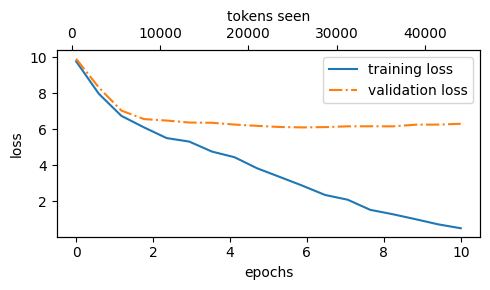

In [45]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [46]:
model.to('cpu')
model.eval()
tokenizer = tiktoken.get_encoding('gpt2')
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_length=GPT_CONFIG_124M['context_length']
)
print('output test:\n', token_ids_to_text(token_ids, tokenizer))

output test:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [47]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v:k for k, v in vocab.items()}
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probs = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probs).item()
print(inverse_vocab[next_token_id])

forward


In [48]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probs, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [49]:
def print_sampled_tokens(probs):
    torch.manual_seed(123)
    sample = [torch.multinomial(probs, num_samples=1) for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

In [50]:
print_sampled_tokens(probs)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [51]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [52]:
temperature = [1, 0.1, 5]
scaled_probs = [softmax_with_temperature(next_token_logits, T) for T in temperature]

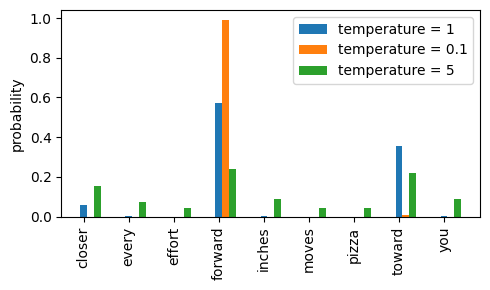

In [53]:
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperature):
    rects = ax.bar(x + i * bar_width, scaled_probs[i], bar_width, label=f"temperature = {T}")
ax.set_ylabel('probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature_plot.pdf")
plt.show()

In [54]:
print_sampled_tokens(scaled_probs[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [55]:
print_sampled_tokens(scaled_probs[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


In [57]:
next_token_logits.shape

torch.Size([9])

In [58]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print('top logits', top_logits)
print('top positions', top_pos)

top logits tensor([6.7500, 6.2800, 4.5100])
top positions tensor([3, 7, 0])


In [59]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [60]:
topk_probs = torch.softmax(new_logits, dim=0)
print(topk_probs)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [65]:
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [73]:
torch.manual_seed(123)
token_idx = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    context_size=GPT_CONFIG_124M['context_length'],
    max_new_tokens=15,
    top_k=25,
    temperature=1.4
)

print('output text:\n', token_ids_to_text(token_idx, tokenizer))

output text:
 Every effort moves youdragged him down his painting?" The word smile the
I looked at


In [74]:
torch.save(model.state_dict(), 'model.pth')

In [76]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load('model.pth'))
model.eval();

In [77]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_and_optimizer.pth')

In [78]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train();

In [80]:
!pip install tensorflow tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 106.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00
  Attempting uni